In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Simulate some data about songs with the following properties:
- Faster songs are more danceable (bpm, danceability)
- Slower songs are more romantic (romanticism)
- There's a parabola describing the relationship between bpm and how much people like a song (likeability)

In [58]:
np.random.seed(123)
bpm = np.random.normal(100, 15, size=10000)
danceability = np.random.normal(0.7, 0.07, size=10000) * bpm + (1 - np.random.normal(0.7, 0.07, size=10000)) * np.random.normal(100, 30, size=10000)
danceability = [(x - np.min(danceability)) / (np.max(danceability) - np.min(danceability)) for x in danceability]
romanticism = - np.random.normal(0.55, 0.07, size=10000) * bpm + (1 - np.random.normal(0.55, 0.07, size=10000)) * np.random.normal(100, 30, size=10000)
romanticism = [(x - np.min(romanticism)) / (np.max(romanticism) - np.min(romanticism)) for x in romanticism]
likeability = [(x - np.min(bpm)) / (np.max(bpm) - np.min(bpm)) for x in bpm] * (np.ones(len(bpm)) - [(x - np.min(bpm)) / (np.max(bpm) - np.min(bpm)) for x in bpm])
likeability = likeability + np.random.normal(0, 0.015, size=10000)
likeability = [(x - np.min(likeability)) / (np.max(likeability) - np.min(likeability)) for x in likeability]

In [60]:
sim_data = pd.DataFrame({
    'bpm': bpm,
    'danceability': danceability,
    'romanticism': romanticism,
    'likeability': likeability
})

sim_data

,bpm,danceability,romanticism,likeability
0,83.715541,0.194148,0.396952,0.770197
1,114.960182,0.396320,0.301968,0.837991
2,104.244677,0.534882,0.357725,0.841988
3,77.405579,0.465752,0.579737,0.627059
4,91.320996,0.666987,0.456434,0.860789
...,...,...,...,...
9995,91.031236,0.430495,0.516167,0.831817
9996,79.031024,0.321633,0.621145,0.678952
9997,92.916004,0.442601,0.711116,0.847378
9998,108.729465,0.648728,0.600346,0.890971


<AxesSubplot:xlabel='bpm', ylabel='danceability'>

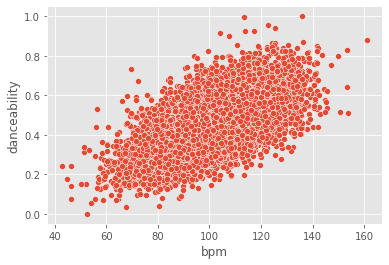

In [61]:
sns.scatterplot(data=sim_data, x='bpm', y='danceability')

<AxesSubplot:xlabel='bpm', ylabel='romanticism'>

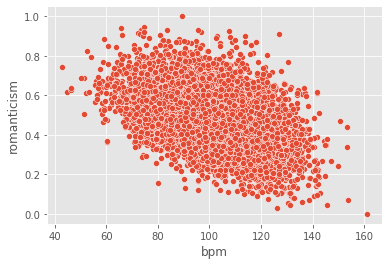

In [62]:
sns.scatterplot(data=sim_data, x='bpm', y='romanticism')

<AxesSubplot:xlabel='bpm', ylabel='likeability'>

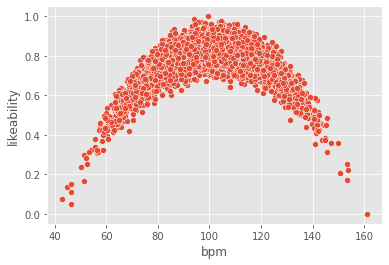

In [63]:
sns.scatterplot(data=sim_data, x='bpm', y='likeability')

In [66]:
sim_data.corr()

,bpm,danceability,romanticism,likeability
bpm,1.000000,0.609353,-0.434363,0.142141
danceability,0.609353,1.000000,-0.261714,0.093039
romanticism,-0.434363,-0.261714,1.000000,-0.041152
likeability,0.142141,0.093039,-0.041152,1.000000


In [68]:
scaler = StandardScaler()
scaled = scaler.fit_transform(sim_data)

In [97]:
results = []
for n in np.linspace(1, 4, 4, dtype='int'):
    pca = PCA(n_components = n)
    reduced = pca.fit_transform(scaled)
    results.append({
        'n_components': n,
        'variance_explained': pca.explained_variance_ratio_[n-1]
    })
    
results = pd.DataFrame(results)
results['explained_variance_ratio_cumulative'] = pca.explained_variance_ratio_.cumsum()

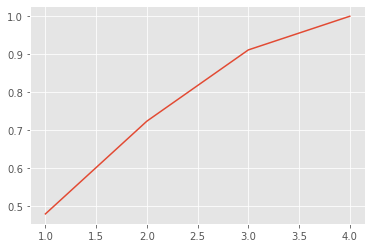

In [99]:
plt.plot(results.n_components, results.explained_variance_ratio_cumulative)

In [100]:
pca = PCA(n_components=3)
reduced = pca.fit_transform(scaled)

In [123]:
pca.explained_variance_ratio_

array([0.4790527 , 0.24447415, 0.18773937])

In [107]:
pca_results = pd.DataFrame(reduced, columns=[f'pc_{x}' for x in range(1, 4)])
pca_results

,pc_1,pc_2,pc_3
0,1.542537,0.126794,-1.726154
1,-1.178836,-0.286973,-1.268670
2,-1.147945,-0.402634,-0.445575
3,1.559077,1.522836,0.754597
4,-0.869378,-0.772141,0.565655
...,...,...,...
9995,0.477339,-0.656632,-0.026635
9996,2.175638,0.802241,0.315532
9997,1.016911,-1.169739,1.212592
9998,-1.071141,-1.326226,1.485018


In [119]:
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'pc_{n+1}' for n in range(pca.n_components_)], index=sim_data.columns)

<AxesSubplot:>

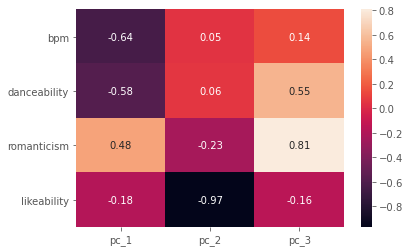

In [122]:
sns.heatmap(loadings, annot=True, fmt='.2f')

- The first principal component is capturing the fact that bpm and danceability tend to go together, while romanticism goes in the opposite direction. This explains 48% of the variability in the data.
- The second principal component is mainly looking at a song's likeability. This accounts for 24% of the variability.
- The third principal component is looking at songs in which danceability and romanticism are both high or both low. This accounts for 19% of the variability.

<AxesSubplot:xlabel='pc_2', ylabel='pc_3'>

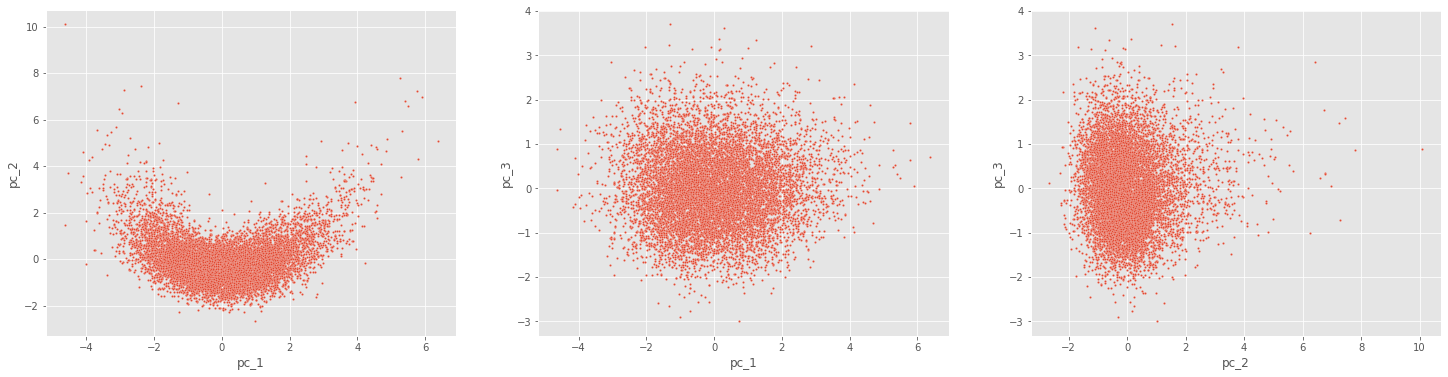

In [143]:
fig, ax = plt.subplots(1, 3, figsize=(25,6))

sns.scatterplot(data=pca_results, x='pc_1', y='pc_2', s=5, ax=ax[0])
sns.scatterplot(data=pca_results, x='pc_1', y='pc_3', s=5, ax=ax[1])
sns.scatterplot(data=pca_results, x='pc_2', y='pc_3', s=5, ax=ax[2])

<AxesSubplot:xlabel='pc_3', ylabel='Density'>

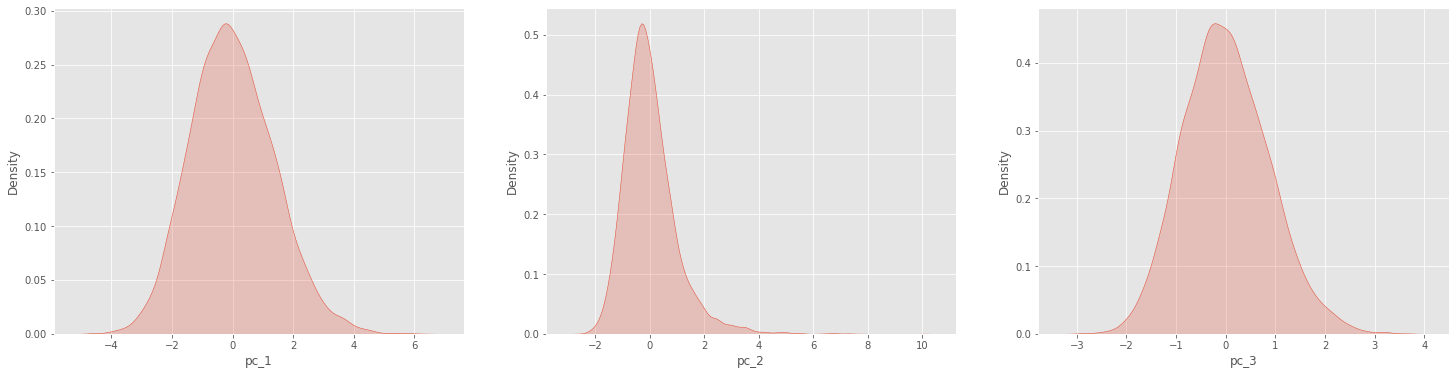

In [146]:
fig, ax = plt.subplots(1, 3, figsize=(25,6))

sns.kdeplot(data=pca_results, x='pc_1', shade=True, ax=ax[0])
sns.kdeplot(data=pca_results, x='pc_2', shade=True, ax=ax[1])
sns.kdeplot(data=pca_results, x='pc_3', shade=True, ax=ax[2])

In [150]:
sim_data.iloc[pca_results.pc_1.argmax(), :]

bpm             52.494170
danceability     0.000000
romanticism      0.823017
likeability      0.251259
Name: 940, dtype: float64

In [151]:
sim_data.iloc[pca_results.pc_1.argmin(), :]

bpm             161.021454
danceability      0.878322
romanticism       0.000000
likeability       0.000000
Name: 8287, dtype: float64

In [152]:
sim_data.iloc[pca_results.pc_2.argmax(), :]

bpm             161.021454
danceability      0.878322
romanticism       0.000000
likeability       0.000000
Name: 8287, dtype: float64

In [153]:
sim_data.iloc[pca_results.pc_2.argmin(), :]

bpm             93.967216
danceability     0.328246
romanticism      0.650911
likeability      0.984540
Name: 5319, dtype: float64

In [154]:
sim_data.iloc[pca_results.pc_3.argmax(), :]

bpm             130.408730
danceability      0.758993
romanticism       0.770041
likeability       0.620861
Name: 1721, dtype: float64

In [155]:
sim_data.iloc[pca_results.pc_3.argmin(), :]

bpm             80.162903
danceability     0.234145
romanticism      0.157034
likeability      0.728756
Name: 1116, dtype: float64

In [158]:
sim_data['pc_1'] = pca_results.pc_1
sim_data['pc_2'] = pca_results.pc_2
sim_data['pc_3'] = pca_results.pc_3

<AxesSubplot:xlabel='pc_3', ylabel='likeability'>

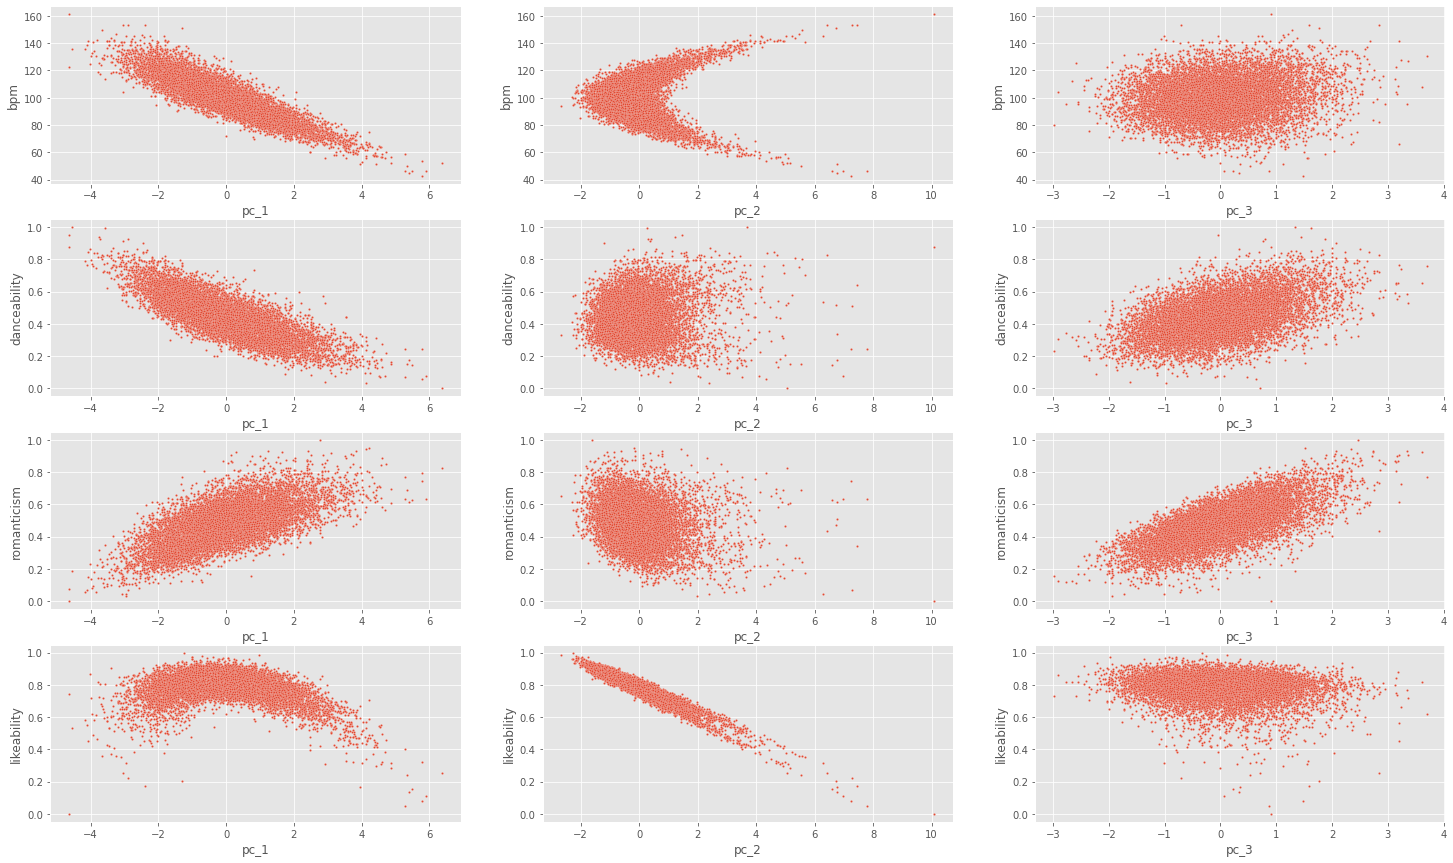

In [163]:
fig, ax = plt.subplots(4, 3, figsize=(25, 15))

sns.scatterplot(data=sim_data, x='pc_1', y='bpm', s=5, ax=ax[0,0])
sns.scatterplot(data=sim_data, x='pc_2', y='bpm', s=5, ax=ax[0,1])
sns.scatterplot(data=sim_data, x='pc_3', y='bpm', s=5, ax=ax[0,2])
sns.scatterplot(data=sim_data, x='pc_1', y='danceability', s=5, ax=ax[1,0])
sns.scatterplot(data=sim_data, x='pc_2', y='danceability', s=5, ax=ax[1,1])
sns.scatterplot(data=sim_data, x='pc_3', y='danceability', s=5, ax=ax[1,2])
sns.scatterplot(data=sim_data, x='pc_1', y='romanticism', s=5, ax=ax[2,0])
sns.scatterplot(data=sim_data, x='pc_2', y='romanticism', s=5, ax=ax[2,1])
sns.scatterplot(data=sim_data, x='pc_3', y='romanticism', s=5, ax=ax[2,2])
sns.scatterplot(data=sim_data, x='pc_1', y='likeability', s=5, ax=ax[3,0])
sns.scatterplot(data=sim_data, x='pc_2', y='likeability', s=5, ax=ax[3,1])
sns.scatterplot(data=sim_data, x='pc_3', y='likeability', s=5, ax=ax[3,2])

Here we can clearly see what each principal component is capturing. Again:
- The first principal component (48% explained variance) is capturing the main patterns: bpm and danceability tend to go together, while romanticism goes in the opposite direction.
- The second principal component (24% explained variance) focuses on likeability.
- The third principal component (18% explained variance) is capturing the special cases of songs that have similar levels of danceability and romanticism. Note that the normal pattern is the one captured by the first principal component. But since each principal component is orthogonal to the rest, the third principal component can only look at the variability that hasn't yet been captured by the first and second principal components.